In [1]:
import QUANTAXIS as QA
import datetime
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

from talib import MA_Type
import talib

from pyecharts import Line
#加载 seaborn，并且设置默认使用 seaborn
import seaborn as sns
sns.set()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
%config InlineBackend.figure_format = 'svg'

### 定义常用方法和参数

In [2]:
def _get_zs_code():
    """获取示例时的指数（沪深300）代码，返回000300或者399300"""

    ZS_CODE = ['399300', '000300']  #指数代码。沪深300
    for z in ZS_CODE:
        if _test_index(z):
            return z
    if not isinstance(ZS_CODE, str):
        raise AssertionError


def _test_index(code, start='2018-01-01', end='2018-12-31'):
    """测试指数数据是否在本地能读取到
    
    Return:
        如果数据读取正常，则返回True，否则返回False
    """
    return not QA.QA_fetch_index_day_adv(code, start, end).data.empty


def _format_date(date_value: datetime.date, fmt='%Y-%m-%d'):
    # pylint: disable=C0301
    """格式化输出日期类型数据


    Args:
        date_value:
        fmt: 格式化字符串。
            参考：https://docs.python.org/zh-cn/3.7/library/datetime.html#strftime-and-strptime-behavior

    Returns:

    """
    return date_value.strftime(fmt)


def _get_start_end_date():
    ds = QA.QA_fetch_index_day_adv(_get_zs_code(),
                                   QA.QAUtil.QADate_trade.trade_date_sse[0],
                                   QA.QAUtil.QADate.QA_util_today_str()).date
    return ds[0], ds[-1]


'获取本地股票列表'
lst = QA.QA_fetch_stock_list_adv()

zs_code = _get_zs_code()
'指数代码:{0}'.format(zs_code)

start_date, end_date = _get_start_end_date()
start_str = QA.QAUtil.QADate.QA_util_datetime_to_strdate(start_date)
end_str = QA.QAUtil.QADate.QA_util_datetime_to_strdate(end_date)
'开始日期:{0}'.format(start_date)
'结束日期:{0}'.format(end_date)

'获取本地股票列表'

'指数代码:399300'

'开始日期:2005-04-08 00:00:00'

'结束日期:2019-01-18 00:00:00'

~~因为 2008-01-23 ~ 2009-02-09 之间有一次较大的分红配送，造成持仓价格下降较多。所以这里修改了结束日期，用来测试计算持仓价格~~

In [3]:
# end_date=datetime.date(2009,2,9)
# end_str=QA.QAUtil.QADate.QA_util_datetime_to_strdate(end_date)

### 创建账户

股票普通账户

https://github.com/QUANTAXIS/QADemo/blob/master/backtest/QUANTAXIS%E5%9B%9E%E6%B5%8B%E5%88%86%E6%9E%90%E5%85%A8%E8%BF%87%E7%A8%8B%E8%AE%B2%E8%A7%A3.ipynb

https://book.yutiansut.com/Documents/QUANTAXIS%E5%9B%9E%E6%B5%8B%E5%88%86%E6%9E%90%E5%85%A8%E8%BF%87%E7%A8%8B%E8%AE%B2%E8%A7%A3.html

In [4]:
stock_account= QA.QA_Account(allow_t0=False,allow_margin=False,allow_sellopen=False,running_environment=QA.MARKET_TYPE.STOCK_CN)
# 重设账户初始资金为1万元
stock_account.reset_assets(10000)

### 初始化回测broker

In [5]:
Broker=QA.QA_BacktestBroker()

### 读取日线数据

In [6]:
data=QA.QA_fetch_stock_day_adv(['000002'],start_str,end_str)

### 根据前复权收盘价，计算加权移动平均线上穿和下穿结果

In [7]:
def _bbands(df,
            ma_type: MA_Type = MA_Type.WMA,
            timeperiod=30,
            nbdevup=2.5,
            nbdevdn=2.5):
    '''
    根据前复权收盘价，计算加权移动平均线上穿和下穿结果
    df:前复权数据
    '''

    UPPER, MIDDLE, LOWER = talib.BBANDS(
        df['close'].values,
        timeperiod=timeperiod,
        matype=ma_type,
        nbdevup=nbdevup,
        nbdevdn=nbdevdn)

    CROSS_UP = QA.CROSS(df.close, UPPER)
    CROSS_DN = QA.CROSS(df.close, LOWER)

    return pd.DataFrame({
        'CROSS_UP': CROSS_UP,
        'CROSS_DN': CROSS_DN,
        'QFQ_CLOSE': df.close,
        'UPPER': UPPER,
        'LOWER': LOWER,
        'MIDDLE':MIDDLE
    })

In [8]:
ind=data.to_qfq().add_func(_bbands)
ind[(ind['CROSS_DN']!=0) | (ind['CROSS_UP']!=0)]

,,CROSS_DN,CROSS_UP,LOWER,MIDDLE,QFQ_CLOSE,UPPER
date,code,,,,,,
2005-07-25,000002,0,1,0.921277,1.012261,1.116735,1.103245
2006-02-06,000002,0,1,1.230447,1.428087,1.665797,1.625726
2006-03-28,000002,0,1,1.498574,1.749712,2.019429,2.000849
2007-05-09,000002,0,1,4.913078,5.846281,6.958952,6.779483
2007-05-14,000002,0,1,4.699021,6.131220,7.652303,7.563419
2007-07-17,000002,0,1,8.397656,9.599008,10.862399,10.800359
2007-07-20,000002,0,1,8.029443,10.002252,12.312640,11.975060
2007-10-31,000002,0,1,13.406701,15.925653,18.694660,18.444605
2008-01-23,000002,1,0,11.423599,13.636528,11.866043,15.849458


### 绘制图表

In [9]:
import units


def _plot_bbands(df,
                 ma_type: MA_Type = MA_Type.WMA,
                 timeperiod=30,
                 nbdevup=2.5,
                 nbdevdn=2.5):
    line = Line(
        "布林带移动平均计算方式", '{0}\n窗口期：{1}'.format(
            units._translate_ma_type(ma_type), timeperiod))

    sale_point = []
    buy_point = []
    for s in df[df['CROSS_UP'] > 0].index.get_level_values(0).date:
        sale_point.append({
            'coord':
            [s.strftime('%Y-%m-%d'),
             np.round(df.loc[s]['QFQ_CLOSE'], 2)],
            "name":
            "可卖"
        })
    for s in df[df['CROSS_DN'] > 0].index.get_level_values(0).date:
        buy_point.append({
            'coord':
            [s.strftime('%Y-%m-%d'),
             np.round(df.loc[s]['QFQ_CLOSE'], 2)],
            "name":
            "可买"
        })

    line_color = {
        'LOWER': '#FFD700',
        'UPPER': '#800000',
        'MIDDLE': '#228B22',
        'QFQ_CLOSE': '#191970'
    }
    mark_point = {
        'UPPER': sale_point,
        'LOWER': buy_point,
        'MIDDLE': None,
        'QFQ_CLOSE': None
    }

    for c in ['LOWER', 'MIDDLE', 'QFQ_CLOSE', 'UPPER']:
        line.add(
            c,
            df.index.get_level_values(0).date,
            np.round(df[c].values, 2),
            is_datazoom_show=True,
            datazoom_type='both',
            mark_point_textcolor="#40ff27",
            line_color=line_color[c],
            mark_point=mark_point[c])

    return line


_plot_bbands(ind)

### 根据可买可卖标记模拟交易操作

In [10]:
for items in data.panel_gen:
    for item in items.security_gen:
        daily_ind=ind.loc[item.index]
        if daily_ind.CROSS_DN.iloc[0]>0:
            order=stock_account.send_order(
                code=item.code[0], 
                time=item.date[0], 
                amount=100, 
                towards=QA.ORDER_DIRECTION.BUY, 
                price=0, 
                order_model=QA.ORDER_MODEL.CLOSE, 
                amount_model=QA.AMOUNT_MODEL.BY_AMOUNT # 按数量下单
                #在按金额下单的时候,应给予 money参数
                #在按数量下单的时候,应给予 amount参数
                )
            #print(item.to_json()[0])
            Broker.receive_order(QA.QA_Event(order=order,market_data=item))
            
            trade_mes=Broker.query_orders(stock_account.account_cookie,'filled')
            res=trade_mes.loc[order.account_cookie,order.realorder_id]
            order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
        elif daily_ind.CROSS_UP.iloc[0]>0:
            if stock_account.sell_available.get(item.code[0], 0)>0:
                order=stock_account.send_order(
                    code=item.code[0], 
                    time=item.date[0], 
                    amount=stock_account.sell_available.get(item.code[0], 0), 
                    towards=QA.ORDER_DIRECTION.SELL, 
                    price=0, 
                    order_model=QA.ORDER_MODEL.MARKET, 
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT # 按数量下单
                    )
                Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                trade_mes=Broker.query_orders(stock_account.account_cookie,'filled')
                res=trade_mes.loc[order.account_cookie,order.realorder_id]
                order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
    stock_account.settle()

<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_LMYQsKIA datetime:2008-01-23 15:00:00 code:000002 amount:100 price:24.71 towards:1 btype:stock_cn order_id:Order_LMYQsKIA account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_BOpzowuL datetime:2009-02-10 09:30:00 code:000002 amount:100 price:7.994999999999999 towards:-1 btype:stock_cn order_id:Order_BOpzowuL account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_LkqomPCF datetime:2009-12-21 15:00:00 code:000002 amount:100 price:10.72 towards:1 btype:stock_cn order_id:Order_LkqomPCF account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_fzYsioGO datetime:2010-04-21 15:00:00 code:000002 amount:100 price:8.11 towards:1 btype:stock_cn order_id:Order_fzYsioGO account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_9Ated654 datetime:2010-07-12 09:30:00 code:000002 amount:200 price:7.465 towards:-1 btype:stock_cn order_id:Order_9Ated654 account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_v6NlhiT7 datetime:2011-09-23 15:00:00 code:000002 amount:100 price:7.4 towards:1 btype:stock_cn order_id:Order_v6NlhiT7 account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_qSECP0yb datetime:2011-09-27 15:00:00 code:000002 amount:100 price:7.17 towards:1 btype:stock_cn order_id:Order_qSECP0yb account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_hQmSxdgX datetime:2012-01-20 09:30:00 code:000002 amount:200 price:7.865 towards:-1 btype:stock_cn order_id:Order_hQmSxdgX account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_gs5jem1w datetime:2013-12-23 15:00:00 code:000002 amount:100 price:7.79 towards:1 btype:stock_cn order_id:Order_gs5jem1w account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_PI7rcvNG datetime:2014-02-26 15:00:00 code:000002 amount:100 price:6.68 towards:1 btype:stock_cn order_id:Order_PI7rcvNG account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_nseMFQGt datetime:2014-05-23 09:30:00 code:000002 amount:200 price:8.024999999999999 towards:-1 btype:stock_cn order_id:Order_nseMFQGt account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_FBmRQAps datetime:2014-10-28 15:00:00 code:000002 amount:100 price:9.02 towards:1 btype:stock_cn order_id:Order_FBmRQAps account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_WX1RnAiv datetime:2014-11-24 09:30:00 code:000002 amount:100 price:10.025 towards:-1 btype:stock_cn order_id:Order_WX1RnAiv account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_PrdHlVFz datetime:2015-08-26 15:00:00 code:000002 amount:100 price:13.25 towards:1 btype:stock_cn order_id:Order_PrdHlVFz account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_BeRn5p39 datetime:2015-12-01 09:30:00 code:000002 amount:100 price:15.754999999999999 towards:-1 btype:stock_cn order_id:Order_BeRn5p39 account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_eDbnIWcz datetime:2017-03-06 15:00:00 code:000002 amount:100 price:20.22 towards:1 btype:stock_cn order_id:Order_eDbnIWcz account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_ImERNUwq datetime:2017-03-14 09:30:00 code:000002 amount:100 price:21.56 towards:-1 btype:stock_cn order_id:Order_ImERNUwq account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_xCZABGhz datetime:2018-06-29 15:00:00 code:000002 amount:100 price:24.6 towards:1 btype:stock_cn order_id:Order_xCZABGhz account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_Rm2XqxNV datetime:2018-07-03 15:00:00 code:000002 amount:100 price:23.42 towards:1 btype:stock_cn order_id:Order_Rm2XqxNV account:Acc_MODw2aiN status:queued >

receive deal
<class 'QUANTAXIS.QAData.QADataStruct.QA_DataStruct_Stock_day'>


< QA_Order realorder_id Order_PIdF9U3i datetime:2018-09-21 09:30:00 code:000002 amount:200 price:24.965 towards:-1 btype:stock_cn order_id:Order_PIdF9U3i account:Acc_MODw2aiN status:queued >

receive deal


#### 账户状态

In [11]:
stock_account.message

{'account_cookie': 'Acc_MODw2aiN',
 'allow_sellopen': False,
 'allow_t0': False,
 'broker': 'backtest',
 'cash': [10000,
  7524.0,
  8317.201,
  7240.200999999999,
  6424.200999999999,
  7909.708999999999,
  7164.708999999999,
  6442.708999999999,
  8010.134999999999,
  7226.134999999999,
  6553.134999999999,
  8150.530999999999,
  7243.530999999999,
  8240.527999999998,
  6910.527999999998,
  8478.952999999998,
  6451.952999999998,
  8600.796999999997,
  6135.796999999997,
  3788.796999999997,
  8770.804999999997],
 'commission_coeff': 0.00025,
 'current_time': 'None',
 'end_date': '2018-09-21',
 'history': [['2008-01-23 00:00:00',
   '000002',
   24.71,
   100,
   7524.0,
   'Order_LMYQsKIA',
   'Order_LMYQsKIA',
   'Trade_5lYDAmdw',
   'Acc_MODw2aiN',
   5,
   0,
   None,
   0],
  ['2009-02-10 00:00:00',
   '000002',
   7.99,
   -100,
   8317.201,
   'Order_BOpzowuL',
   'Order_BOpzowuL',
   'Trade_Mj0N6I8a',
   'Acc_MODw2aiN',
   5,
   0.799,
   None,
   0],
  ['2009-12-21 00:00:00

#### 账户持仓数量

In [12]:
stock_account.sell_available.get('000002')

#### 账户按照股票代码分组后的持仓数量

In [13]:
stock_account.hold_table()

Series([], Name: amount, dtype: object)

#### 账户按照股票代码分组后的持仓成本

In [14]:
stock_account.hold_price('2008-01-24')

code
000002    (24.71, 100.0)
dtype: object

**2008-08月份，进行过一次分红，但是这里的价格没有做处理**

**看上去应该使用从购买日期开始至卖出日期间的后复权价来计算**

In [15]:
stock_account.hold_price('2008-07-01')

code
000002    (24.71, 100.0)
dtype: object

In [16]:
stock_account.hold_available.values

array([], dtype=float64)

### 账户交易记录

#### 交易明细Json格式

In [17]:
stock_account.history

[['2008-01-23 00:00:00',
  '000002',
  24.71,
  100,
  7524.0,
  'Order_LMYQsKIA',
  'Order_LMYQsKIA',
  'Trade_5lYDAmdw',
  'Acc_MODw2aiN',
  5,
  0,
  None,
  0],
 ['2009-02-10 00:00:00',
  '000002',
  7.99,
  -100,
  8317.201,
  'Order_BOpzowuL',
  'Order_BOpzowuL',
  'Trade_Mj0N6I8a',
  'Acc_MODw2aiN',
  5,
  0.799,
  None,
  0],
 ['2009-12-21 00:00:00',
  '000002',
  10.72,
  100,
  7240.200999999999,
  'Order_LkqomPCF',
  'Order_LkqomPCF',
  'Trade_WRq3Ulti',
  'Acc_MODw2aiN',
  5,
  0,
  None,
  0],
 ['2010-04-21 00:00:00',
  '000002',
  8.11,
  100,
  6424.200999999999,
  'Order_fzYsioGO',
  'Order_fzYsioGO',
  'Trade_9iM8Ak4G',
  'Acc_MODw2aiN',
  5,
  0,
  None,
  0],
 ['2010-07-12 00:00:00',
  '000002',
  7.46,
  -200,
  7909.708999999999,
  'Order_9Ated654',
  'Order_9Ated654',
  'Trade_cgS26vMC',
  'Acc_MODw2aiN',
  5,
  1.492,
  None,
  0],
 ['2011-09-23 00:00:00',
  '000002',
  7.4,
  100,
  7164.708999999999,
  'Order_v6NlhiT7',
  'Order_v6NlhiT7',
  'Trade_DjHcOY54',
 

#### 交易明细 DataFrame 格式

In [18]:
stock_account.history_table

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message,frozen
0,2008-01-23 00:00:00,000002,24.71,100,7524.000,Order_LMYQsKIA,Order_LMYQsKIA,Trade_5lYDAmdw,Acc_MODw2aiN,5,0.000,None,0
1,2009-02-10 00:00:00,000002,7.99,-100,8317.201,Order_BOpzowuL,Order_BOpzowuL,Trade_Mj0N6I8a,Acc_MODw2aiN,5,0.799,None,0
2,2009-12-21 00:00:00,000002,10.72,100,7240.201,Order_LkqomPCF,Order_LkqomPCF,Trade_WRq3Ulti,Acc_MODw2aiN,5,0.000,None,0
3,2010-04-21 00:00:00,000002,8.11,100,6424.201,Order_fzYsioGO,Order_fzYsioGO,Trade_9iM8Ak4G,Acc_MODw2aiN,5,0.000,None,0
4,2010-07-12 00:00:00,000002,7.46,-200,7909.709,Order_9Ated654,Order_9Ated654,Trade_cgS26vMC,Acc_MODw2aiN,5,1.492,None,0
5,2011-09-23 00:00:00,000002,7.40,100,7164.709,Order_v6NlhiT7,Order_v6NlhiT7,Trade_DjHcOY54,Acc_MODw2aiN,5,0.000,None,0
6,2011-09-27 00:00:00,000002,7.17,100,6442.709,Order_qSECP0yb,Order_qSECP0yb,Trade_sF2g3SDc,Acc_MODw2aiN,5,0.000,None,0
7,2012-01-20 00:00:00,000002,7.87,-200,8010.135,Order_hQmSxdgX,Order_hQmSxdgX,Trade_IJoU5Chm,Acc_MODw2aiN,5,1.574,None,0
8,2013-12-23 00:00:00,000002,7.79,100,7226.135,Order_gs5jem1w,Order_gs5jem1w,Trade_6Lc3HEZs,Acc_MODw2aiN,5,0.000,None,0
9,2014-02-26 00:00:00,000002,6.68,100,6553.135,Order_PI7rcvNG,Order_PI7rcvNG,Trade_0ymeYHl3,Acc_MODw2aiN,5,0.000,None,0


In [19]:
stock_account.cash_table

,,cash,datetime,date,account_cookie
datetime,account_cookie,,,,
2008-01-23 00:00:00,Acc_MODw2aiN,7524,2008-01-23 00:00:00,2008-01-23,Acc_MODw2aiN
2009-02-10 00:00:00,Acc_MODw2aiN,8317.2,2009-02-10 00:00:00,2009-02-10,Acc_MODw2aiN
2009-12-21 00:00:00,Acc_MODw2aiN,7240.2,2009-12-21 00:00:00,2009-12-21,Acc_MODw2aiN
2010-04-21 00:00:00,Acc_MODw2aiN,6424.2,2010-04-21 00:00:00,2010-04-21,Acc_MODw2aiN
2010-07-12 00:00:00,Acc_MODw2aiN,7909.71,2010-07-12 00:00:00,2010-07-12,Acc_MODw2aiN
2011-09-23 00:00:00,Acc_MODw2aiN,7164.71,2011-09-23 00:00:00,2011-09-23,Acc_MODw2aiN
2011-09-27 00:00:00,Acc_MODw2aiN,6442.71,2011-09-27 00:00:00,2011-09-27,Acc_MODw2aiN
2012-01-20 00:00:00,Acc_MODw2aiN,8010.13,2012-01-20 00:00:00,2012-01-20,Acc_MODw2aiN
2013-12-23 00:00:00,Acc_MODw2aiN,7226.13,2013-12-23 00:00:00,2013-12-23,Acc_MODw2aiN


### 账户分析

In [20]:
Risk=QA.QA_Risk(stock_account,benchmark_code=zs_code)

In [21]:
Risk.market_value.diff().iloc[-1]

code
000002   -4802.0
Name: (2018-09-21 00:00:00, Acc_MODw2aiN), dtype: float64

In [22]:
Risk.account.cash_table

,,cash,datetime,date,account_cookie
datetime,account_cookie,,,,
2008-01-23 00:00:00,Acc_MODw2aiN,7524,2008-01-23 00:00:00,2008-01-23,Acc_MODw2aiN
2009-02-10 00:00:00,Acc_MODw2aiN,8317.2,2009-02-10 00:00:00,2009-02-10,Acc_MODw2aiN
2009-12-21 00:00:00,Acc_MODw2aiN,7240.2,2009-12-21 00:00:00,2009-12-21,Acc_MODw2aiN
2010-04-21 00:00:00,Acc_MODw2aiN,6424.2,2010-04-21 00:00:00,2010-04-21,Acc_MODw2aiN
2010-07-12 00:00:00,Acc_MODw2aiN,7909.71,2010-07-12 00:00:00,2010-07-12,Acc_MODw2aiN
2011-09-23 00:00:00,Acc_MODw2aiN,7164.71,2011-09-23 00:00:00,2011-09-23,Acc_MODw2aiN
2011-09-27 00:00:00,Acc_MODw2aiN,6442.71,2011-09-27 00:00:00,2011-09-27,Acc_MODw2aiN
2012-01-20 00:00:00,Acc_MODw2aiN,8010.13,2012-01-20 00:00:00,2012-01-20,Acc_MODw2aiN
2013-12-23 00:00:00,Acc_MODw2aiN,7226.13,2013-12-23 00:00:00,2013-12-23,Acc_MODw2aiN


In [23]:
Risk.market_value.sum(axis=1)

date        account_cookie
2008-01-23  Acc_MODw2aiN      1186.604273
2008-01-24  Acc_MODw2aiN      1216.377428
2008-01-25  Acc_MODw2aiN      1296.572861
2008-01-28  Acc_MODw2aiN      1226.942096
2008-01-29  Acc_MODw2aiN      1249.992280
2008-01-30  Acc_MODw2aiN      1229.343157
2008-01-31  Acc_MODw2aiN      1250.952704
2008-02-01  Acc_MODw2aiN      1296.572861
2008-02-04  Acc_MODw2aiN      1394.055931
2008-02-05  Acc_MODw2aiN      1354.678533
2008-02-13  Acc_MODw2aiN      1310.499013
2008-02-14  Acc_MODw2aiN      1307.617740
2008-02-15  Acc_MODw2aiN      1270.641403
2008-02-18  Acc_MODw2aiN      1305.696892
2008-02-19  Acc_MODw2aiN      1324.425166
2008-02-20  Acc_MODw2aiN      1258.155887
2008-02-21  Acc_MODw2aiN      1210.134670
2008-02-22  Acc_MODw2aiN      1152.028997
2008-02-25  Acc_MODw2aiN      1095.363961
2008-02-26  Acc_MODw2aiN      1095.844173
2008-02-27  Acc_MODw2aiN      1131.379874
2008-02-28  Acc_MODw2aiN      1104.007780
2008-02-29  Acc_MODw2aiN      1116.493297
2008-03

In [24]:
Risk.profit_construct

{'total_buyandsell': -1114.0,
 'total_commission': -100.0,
 'total_profit': -1229.2,
 'total_tax': -15.2}

<module 'matplotlib.pyplot' from 'C:\\Users\\GuQiang\\AppData\\Local\\conda\\conda\\envs\\finance35\\lib\\site-packages\\matplotlib\\pyplot.py'>

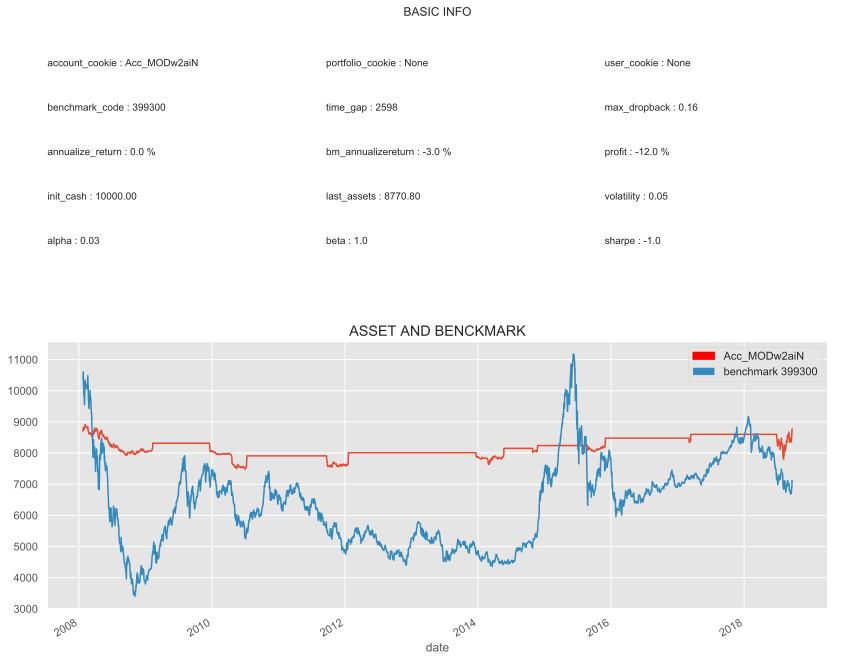

In [25]:
Risk.plot_assets_curve()

In [26]:
Performance=QA.QA_Performance(stock_account)

In [27]:
Performance.pnl_fifo

,sell_date,buy_date,amount,sell_price,buy_price,pnl_ratio,pnl_money
code,,,,,,,
000002,2009-02-10,2008-01-23,100,7.99,24.71,-0.676649,-1672.0
000002,2010-07-12,2010-04-21,100,7.46,8.11,-0.080148,-65.0
000002,2010-07-12,2009-12-21,100,7.46,10.72,-0.304104,-326.0
000002,2012-01-20,2011-09-27,100,7.87,7.17,0.097629,70.0
000002,2012-01-20,2011-09-23,100,7.87,7.40,0.063514,47.0
000002,2014-05-23,2014-02-26,100,8.02,6.68,0.200599,134.0
000002,2014-05-23,2013-12-23,100,8.02,7.79,0.029525,23.0
000002,2014-11-24,2014-10-28,100,10.03,9.02,0.111973,101.0
000002,2015-12-01,2015-08-26,100,15.75,13.25,0.188679,250.0


### 采用复权价计算后的账户分析

In [51]:
class QA_Performance_Ext(QA.QA_Performance):
    '''此方法包含在finance_ai_py\quantaxis_ext.py'''
    @property
    def pnl_fifo_qfq(self):
        pnl = super(QA_Performance_Ext, self).pnl_fifo
#         pnl['buy_price_qfq'] = pnl['buy_price']
        pnl=pnl.reset_index()
        for idx in pnl.index:
            s = QA.QAUtil.QADate.QA_util_datetime_to_strdate(pnl.loc[idx, 'buy_date'])
            e = QA.QAUtil.QADate.QA_util_datetime_to_strdate(pnl.loc[idx, 'sell_date'])
            c=pnl.loc[idx,'code']
            new_value = QA.QA_fetch_stock_day_adv(c,s, e).to_qfq()
            pnl.loc[idx, 'buy_price_qfq'] = np.round(new_value.select_day(s).close[0], 4)
        pnl = pnl.assign(
            pnl_money_qfq=(pnl.sell_price - pnl.buy_price_qfq) * pnl.amount
        )
        return pnl.set_index('code')
            
Performance_ext=QA_Performance_Ext(stock_account)
Performance_ext.pnl_fifo_qfq

,sell_date,buy_date,amount,sell_price,buy_price,pnl_ratio,pnl_money,buy_price_qfq,pnl_money_qfq
code,,,,,,,,,
000002,2009-02-10,2008-01-23,100,7.99,24.71,-0.676649,-1672.0,15.3502,-736.02
000002,2010-07-12,2010-04-21,100,7.46,8.11,-0.080148,-65.0,8.0280,-56.80
000002,2010-07-12,2009-12-21,100,7.46,10.72,-0.304104,-326.0,10.6116,-315.16
000002,2012-01-20,2011-09-27,100,7.87,7.17,0.097629,70.0,7.1700,70.00
000002,2012-01-20,2011-09-23,100,7.87,7.40,0.063514,47.0,7.4000,47.00
000002,2014-05-23,2014-02-26,100,8.02,6.68,0.200599,134.0,6.3320,168.80
000002,2014-05-23,2013-12-23,100,8.02,7.79,0.029525,23.0,7.3842,63.58
000002,2014-11-24,2014-10-28,100,10.03,9.02,0.111973,101.0,9.0200,101.00
000002,2015-12-01,2015-08-26,100,15.75,13.25,0.188679,250.0,13.2500,250.00


In [52]:
Performance.pnl_fifo.pnl_money.sum()
Performance_ext.pnl_fifo_qfq.pnl_money_qfq.sum()

-1114.0

97.08000000000055